# Instance creator utility

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.io import loadmat
import pandas as pd
from pathlib import Path

from matplotlib import rcParams
#rcParams['text.usetex'] = True

sys.path.append('..')
import res.models.Fleet as Fleet
import res.models.ElectricVehicle as EV

import res.models.Network as Network
import res.models.Node as Node
import res.models.Edge as Edge

### Variables setting

In [2]:
main_folder = Path('../data/online/')
mat_path = Path('../data/mat_files/Santiago22.mat')
std_factor = 1

fig_width, fig_height = 10, 12.941
full_figratio = (fig_width, fig_height)

## Standard travel time and energy consumption profile

In [3]:
def edge_data(data, i, j, t):
    soc_data = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['soc'][0]*24/(1000*3600) # Ws
    tt_data  = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['time'][0] # s
    soc_mean, tt_mean = np.mean(soc_data), np.mean(tt_data)
    soc_std, tt_std = np.std(soc_data), np.std(tt_data)    
    return (soc_mean, tt_mean), (soc_std, tt_std)

data = loadmat(mat_path)

network_size = len(data['starting_time'][0][0]['origin'][0])
data_points = len(data['starting_time'][0])

soc_mean_matrix, tt_mean_matrix, v_mean_matrix = np.zeros((1, data_points)), np.zeros((1, data_points)), np.zeros((1, data_points))
soc_std_matrix, tt_std_matrix, v_std_matrix = np.zeros((1, data_points)), np.zeros((1, data_points)), np.zeros((1, data_points))

samples = 0

for i in range(network_size):
    for j in range(network_size):
        if i != j:
            (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, 0)
            v_avg = 40*1000/3600
            dij = tt_mean*v_avg  # m
            if dij == .0:
                continue
            soc_array_mean, tt_array_mean, v_array_mean = np.zeros((1, data_points)), np.zeros((1, data_points)), np.zeros((1, data_points))
            soc_array_std, tt_array_std, v_array_std = np.zeros((1, data_points)), np.zeros((1, data_points)), np.zeros((1, data_points))
            for t in range(data_points):
                (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, t)
                t1km_mean = tt_mean/dij # s
                t1km_std = tt_std/dij # s
                E1km_mean = soc_mean/dij # Ws
                E1km_std = soc_std/dij # Ws
                tt_array_mean[0, t] = t1km_mean
                soc_array_mean[0, t] = E1km_mean
                tt_array_std[0, t] = t1km_std
                soc_array_std[0, t] = E1km_std
                
                v_array_mean[0, t] = dij/tt_mean
                v_array_std[0, t] = 7*std_factor*tt_std*(dij/tt_mean)**2/dij
                
            soc_mean_matrix = np.append(soc_mean_matrix, soc_array_mean, axis = 0)
            tt_mean_matrix = np.append(tt_mean_matrix, tt_array_mean, axis = 0)
            soc_std_matrix = np.append(soc_std_matrix, soc_array_std, axis = 0)
            tt_std_matrix = np.append(tt_std_matrix, tt_array_std, axis = 0)
            
            v_mean_matrix = np.append(v_mean_matrix, v_array_mean, axis = 0)
            v_std_matrix = np.append(v_std_matrix, v_array_std, axis = 0)
            
tt_mean_matrix = tt_mean_matrix[1:, :]
tt_std_matrix = tt_std_matrix[1:, :]

soc_mean_matrix = soc_mean_matrix[1:, :]
soc_std_matrix = soc_std_matrix[1:, :]

v_mean_matrix = v_mean_matrix[1:, :]
v_std_matrix = v_std_matrix[1:, :]

In [4]:
tt_mean = np.mean(tt_mean_matrix, axis=0)
ec_mean = np.mean(soc_mean_matrix, axis=0)

tt_std = np.mean(tt_std_matrix, axis=0)
ec_std = np.mean(soc_std_matrix, axis=0)

x = range(len(tt_mean))

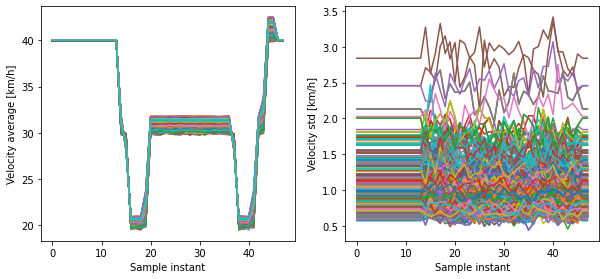

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height/3))

for _ in range(v_mean_matrix.shape[0]):
    v_index = np.random.randint(0, v_mean_matrix.shape[0])
    ax1.plot(v_mean_matrix[v_index, :] * 3.6)
    ax1.set_xlabel("Sample instant")
    ax1.set_ylabel("Velocity average [km/h]")
    
    ax2.plot(v_std_matrix[v_index, :]*3.6)
    ax2.set_xlabel("Sample instant")
    ax2.set_ylabel("Velocity std [km/h]")

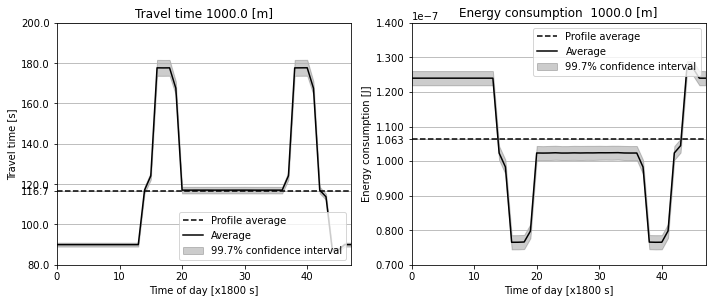

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height/3))

d = 1000.0

y = d*tt_mean
y0 = y - 3*d*tt_std
y1 = y + 3*d*tt_std
tt_mean_global = np.mean(y)

color = 'black'
#ax1.errorbar(x, tt_mean, tt_std, color=color)
ax1.fill_between(x, y0, y1, alpha=.2, color=color, label='99.7% confidence interval')
ax1.axhline(tt_mean_global, color=color, linestyle='--', label='Profile average')
ax1.plot(x, y, marker='', markersize=4, color='k', label='Average')

ax1.set_xlabel('Time of day [x1800 s]')
ax1.set_ylabel('Travel time [s]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(list(ax1.get_yticks()) + [tt_mean_global])
ax1.set_title(f'Travel time {d} [m]')
ax1.set_xlim(0, 47)
ax1.grid(axis='y')
ax1.legend(loc='lower right', fontsize=10)


y = d*ec_mean
y0 = y - 3*d*ec_std
y1 = y + 3*d*ec_std
ec_mean_global = np.mean(y)

color = 'black'
#ax2.errorbar(x, ec_mean, 3*ec_std, color=color, elinewidth=.8)
ax2.fill_between(x, y0, y1, alpha=.2, color = color, label='99.7% confidence interval')
ax2.axhline(ec_mean_global, color=color, linestyle='--', label='Profile average')
ax2.plot(x, y, color=color, label='Average')

ax2.set_xlabel('Time of day [x1800 s]')
ax2.set_ylabel('Energy consumption [J]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(list(ax2.get_yticks()) + [ec_mean_global])
ax2.grid(axis='y')
ax2.set_title(f'Energy consumption  {d} [m]')
ax2.set_xlim(0, 47)
ax2.legend(loc='upper right', fontsize=10)

#fig.suptitle(f'1-Kilometer Profile')
fig.tight_layout()
#fig.subplots_adjust(top=0.85)

In [7]:
#fig.savefig('../data/online/instance21/1kmProfile.pdf')

## Create network

### Network params

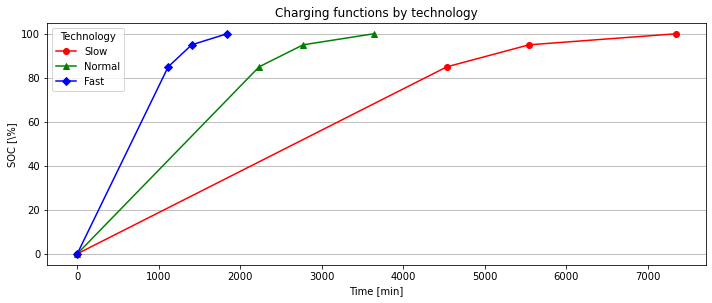

In [48]:
n_customers = 30
n_charg_sta = 5
#minx, maxx = -20000, 20000 # m
#miny, maxy = -20000, 20000 # m
min_radius, max_radius = 500, 25000 # m
min_theta, max_theta = 0, 2 * np.pi
minreq, maxreq = 1, 10 # kg
mintime, maxtime = 60*5, 60*18 # s
mintw_low, maxtw_low = 8*60*60, 13*60*60 # s
mintw_width, maxtw_width = 2*60*60, 5*60*60 # s
cs_capacity = 2

# CS technologies
tech1 = {0.0: 0.0, 75.6*60: 85.0, 92.4*60: 95.0, 122.4*60: 100.0} # slow
tech2 = {0.0: 0.0, 37.2*60: 85.0, 46.2*60: 95.0, 60.6*60: 100.0}  # normal
tech3 = {0.0: 0.0, 18.6*60: 85.0, 23.4*60: 95.0, 30.6*60: 100.0}  # fast
tech_list = [tech1, tech2, tech3]
tech_price = [70., 70.*1.5, 70.*2.5]
tech_name = ["Slow", "Normal", "Fast"]
cs_pos = [(max_radius/2, max_radius/2), (-max_radius/2, max_radius/2), (-max_radius/2, -max_radius/2), 
          (max_radius/2, -max_radius/2)]

# Plot charging functions
fig, ax = plt.subplots(figsize=(fig_width, fig_height/3))
style_list = [('Slow', '-ro'), ('Normal', '-g^'), ('Fast', '-bD')]
for tech, (label, style) in zip(tech_list, style_list):
    t = list(tech.keys())
    soc = list(tech.values())
    ax.plot(t, soc, style, label=label)
    
ax.set_xlabel('Time [min]')
ax.set_ylabel('SOC [\%]')
ax.set_title('Charging functions by technology')
ax.grid(axis='y')    
ax.legend(title='Technology')
fig.tight_layout()
#fig.savefig('../pictures/chargingFunctions.pdf')

### Instance network

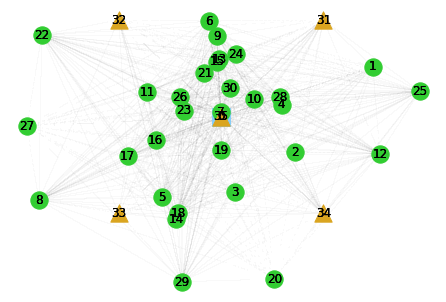

In [49]:
# Dictionaries with nodes and edges
nodes = {}
edges = {}

for i in range(1 + n_customers + n_charg_sta):
    r = np.random.uniform(min_radius, max_radius)
    theta = np.random.uniform(min_theta, max_theta)
    #cx = float('{:.2f}'.format(np.random.uniform(minx, maxx)))
    #cy = float('{:.2f}'.format(np.random.uniform(miny, maxy)))
    cx = float('{:.2f}'.format(r*np.cos(theta)))
    cy = float('{:.2f}'.format(r*np.sin(theta)))
    
    # Depot
    if i == 0:
        node = Node.DepotNode(0, 0, 0, 0, 0)

    # Customers
    elif 1 <= i < 1 + n_customers:
        spent_time = float('{:.2f}'.format(np.random.uniform(mintime, maxtime)))
        demand = float('{:.2f}'.format(np.random.uniform(minreq, maxreq)))
        tw_low = float('{:.2f}'.format(np.random.uniform(mintw_low, maxtw_low)))
        tw_upp = float('{:.2f}'.format(tw_low + np.random.uniform(mintw_width, maxtw_width)))
        node = Node.CustomerNode(i, spent_time, demand, cx, cy, tw_low, tw_upp)

    # Charging Stations
    elif 1 <= i < n_customers + n_charg_sta:
#         j = np.random.randint(3)
        j = 1
        cx, cy = cs_pos[i - (n_customers + n_charg_sta)]
        time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
        node = Node.ChargingStationNode(i, pos_x=cx, pos_y=cy, capacity=cs_capacity, time_points=time_points,
                                        soc_points=soc_points, technology=j + 1, technology_name=tech_name[j],
                                        price=tech_price[j])
    # Charging station at depot
    else:
#         j = np.random.randint(3)
        j = 1
        time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
        node = Node.ChargingStationNode(i, pos_x=0., pos_y=0., capacity=cs_capacity, time_points=time_points,
                                        soc_points=soc_points, technology=j + 1, technology_name=tech_name[j],
                                        price=tech_price[j])
        
    nodes[i] = node
    
# Edges
for i in range(1 + n_customers + n_charg_sta):
    edges[i] = {}
    for j in range(1 + n_customers + n_charg_sta):
        a, b = nodes[i], nodes[j]
        dist = np.sqrt((a.pos_x-b.pos_x)**2 + (a.pos_y-b.pos_y)**2)
        if dist:
            v_index = np.random.randint(0, v_mean_matrix.shape[0])
            v_mean = v_mean_matrix[v_index, :]
            v_std = v_std_matrix[v_index, :]
        else:
            v_mean = np.zeros_like(v_mean_matrix[0, :])
            v_std = np.zeros_like(v_mean_matrix[0, :]) 
        length_profile = np.array([dist])
        inclination_profile = np.array([0])
        
        edge = Edge.GaussianEdge(i, j, dist, 1800, v_mean, length_profile, inclination_profile, velocity_deviation=v_std)
        
        edges[i][j] = edge

# Instance network
network_det = Network.DeterministicCapacitatedNetwork(nodes, edges)
network_sto = Network.GaussianCapacitatedNetwork(nodes, edges)
network_sto.draw(save_to=None, width=0.003, edge_color='grey')
plt.show()

In [50]:
# Save network
network_det.write_xml(Path(main_folder, 'network_det.xml'))
network_sto.write_xml(Path(main_folder, 'network_sto.xml'))

## Create fleet

### Fleet params

In [43]:
ev_id = 0
alpha_down, alpha_upp = 20, 95
battery_capacity = 24000*3600  # J
battery_capacity_nominal = battery_capacity
max_payload = 553 # kg
weight = 1.52*1000  # kg
max_tour_duration = 6*60.*60 # s

### Instance fleet

In [44]:
det_ev = EV.ElectricVehicle(ev_id, weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, 
                                max_payload)
nor_ev = EV.GaussianElectricVehicle(ev_id, weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, 
                                max_payload)

det_fleet = Fleet.Fleet({0: det_ev})
gaus_fleet = Fleet.GaussianFleet({0: nor_ev})

### Save fleet

In [45]:
det_fleet.write_xml(f'{main_folder}/deterministic_fleet.xml', False, print_pretty=True)
gaus_fleet.write_xml(f'{main_folder}/gaussian_fleet.xml', False, print_pretty=True)